In [1]:
import sys
import os

import scipy.ndimage
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice
from isca_tools.land import write_land
from isca_tools.run.create_files import write_var

2025-02-06 16:18:32,586 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_dir = 'rossbypalooza/sst_observation/test_const_time/'

## Create land
Create zonal strip of land.

In [3]:
lat_min = 20
lat_max = 70
if not os.path.isfile(isca_path+exp_dir+'land.nc'):
    write_land(isca_path+exp_dir+'land', isca_path+exp_dir+'namelist.nml', 'square', [lat_min, lat_max, 0-10, 360+10])

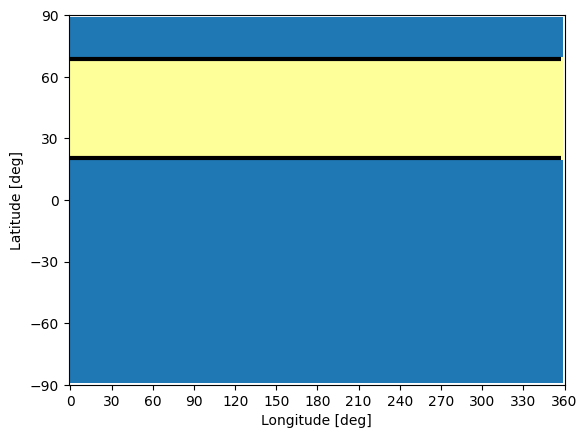

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Write SST file from observations
### Load in observations
Below, I smooth the Earth SST observations averaged from 1991-2020 to create an SST array

(0.0, 90.0)

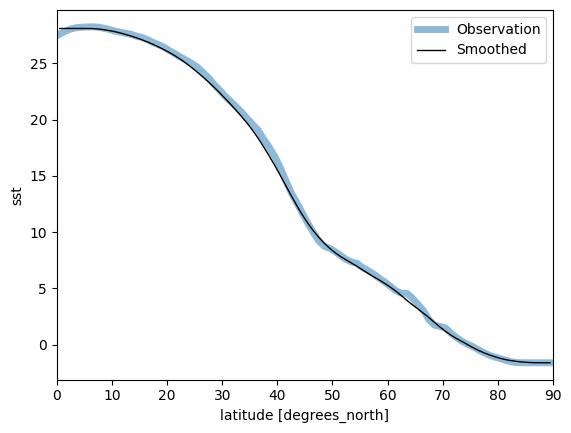

In [7]:
sst_obs = xr.load_dataset(isca_path+exp_dir+'sst.oisst.mon.ltm.1991-2020.nc', decode_times=False).mean(dim=['lon', 'time']).sst

# Smooth observations - only consider observations
sst_obs_smooth = scipy.ndimage.convolve1d(sst_obs, np.ones(10)/10, mode='nearest')[sst_obs.lat>0]
if sst_obs_smooth.argmax() != 0:
    sst_obs_smooth[:sst_obs_smooth.argmax()] = sst_obs_smooth.max()         # make equatorial value the same as the max value
sst_obs[sst_obs.lat>0].plot(lw=5, alpha=0.5, label='Observation')
plt.plot(sst_obs.lat[sst_obs.lat>0], sst_obs_smooth, lw=1, color='k', label='Smoothed')
plt.legend()
plt.xlim(0, 90)

### Save observations
Below, I interpolate the observed sst onto the lat-lon grid of resolution of the experiment. I then write this interpolated array to the experiment directory.

In [12]:
# Load in grid file of correct resolution, to get lat-lon info for simulation.
namelist = isca_tools.load_namelist(exp_dir, data_dir=job_dir, namelist_file='namelist.nml')
res_exp = int(namelist['experiment_details']['resolution'][1:])     # resolution for experiment read in
grid_dir = '/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/grid_files/'
ds_res = xr.load_dataset(os.path.join(grid_dir, f"t{res_exp}_grid.nc"))

sst file already exists


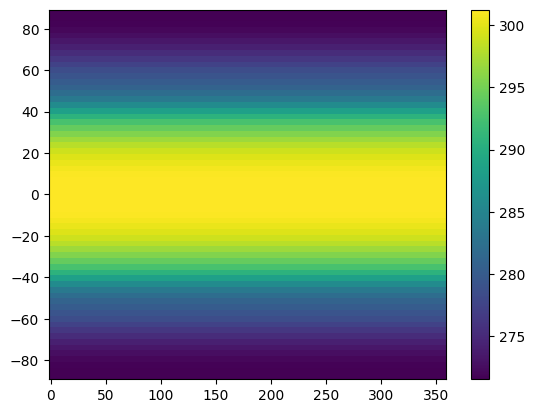

In [22]:
sst_obs_to_save = np.interp(np.abs(ds_res.lat), sst_obs.lat[sst_obs.lat>0], sst_obs_smooth)
sst_obs_to_save = np.tile(sst_obs_to_save[:, np.newaxis], [1, ds_res.lon.size])          # Add longitude axis
sst_obs_to_save = sst_obs_to_save + 273.15  # convert to kelvin

try:
    im = plt.pcolormesh(ds_res.lon, ds_res.lat, sst_obs_to_save)
    plt.colorbar(im)
    write_var('sst', os.path.join(job_dir, exp_dir), var_array=sst_obs_to_save,
              lat_var=ds_res.lat.to_numpy(), lon_var=ds_res.lon.to_numpy())
except ValueError:
    print('sst file already exists')

### Load in and plot saved SST

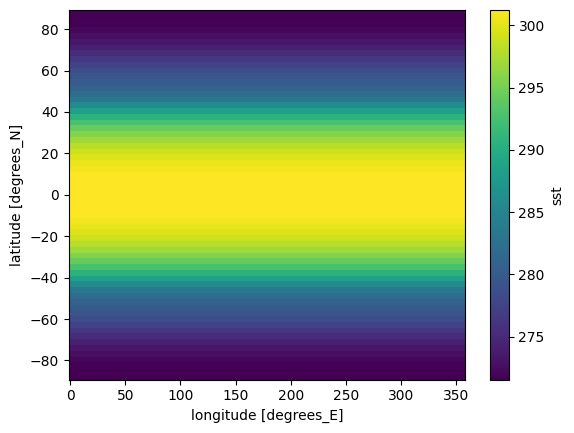

In [20]:
# Plot saved sst
sst_saved = xr.load_dataset(os.path.join(job_dir, exp_dir)+'sst.nc')
im = sst_saved.sst.plot()

## Sanity check that this is SST in simulation
For land, SST changes with time, but it does not for ocean.

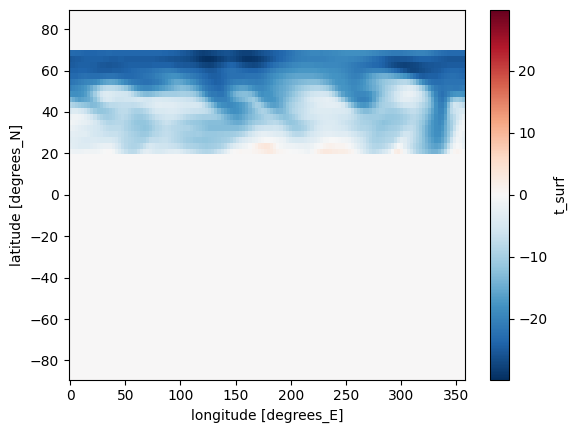

In [23]:
ds = isca_tools.load_dataset(exp_dir)['t_surf']
(ds.isel(time=-1)-ds.isel(time=0)).plot()

In [33]:
# Check that it is same as input sst
lat_ocean, lon_ocean = get_ocean_coords(land_file=os.path.join(job_dir,exp_dir,'land.nc'))
np.round(np.max(np.abs(ds.sel(lat=lat_ocean, method='nearest').to_numpy() -
                       sst_saved.sst.sel(lat=lat_ocean, method='nearest').to_numpy()[np.newaxis]), axis=(1, 2)), 6)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)